
# Generative adversarial networks


Training GAN to generate human faces

In [ ]:
!pip install -r /path/to/requirements.txt

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Data Processing

We take [Flickr Faces](https://github.com/NVlabs/ffhq-dataset) as a training dataset in 1024х1024 resolution [link](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

In [ ]:
# Downloading zip

!gdown --id  1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9

Downloading...
From: https://drive.google.com/uc?id=1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9
To: /content/faces_dataset_small.zip
4.28GB [01:12, 59.2MB/s]


In [ ]:
# Unzipping folder

!unzip -q faces_dataset_small.zip  && rm faces_dataset_small.zip

In [ ]:
batch_size = 64
image_size = 128

latent_size = 1024 # choose latent size

DATA_DIR = '/content/drive/MyDrive/faces_dataset_small'
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
def get_dataloader(data_path, batch_size, image_size):
    train_ds = ImageFolder(data_path,  transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return train_dl

In [ ]:
train_ds = get_dataloader(DATA_DIR, batch_size, image_size)
print(f'Number of batches: {len(train_ds)}') 

Number of batches: 50


In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach())[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def save_samples(index, latent_tensors, show=False):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=8)
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.cpu()).detach(), nrow=8).permute(1, 2, 0))


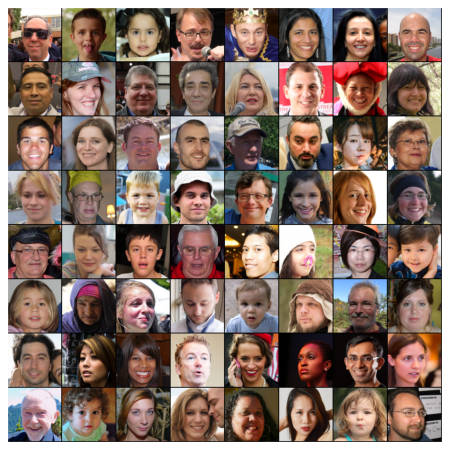

In [ ]:
show_batch(train_ds)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_dl = DeviceDataLoader(train_ds, device)

## The GAN Model Architecture

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 32 x 64 x 64

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Sigmoid(),
    nn.Flatten())


In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(in_channels=latent_size, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    # out: 32 x 64 x 64


    nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

torch.Size([64, 3, 128, 128])


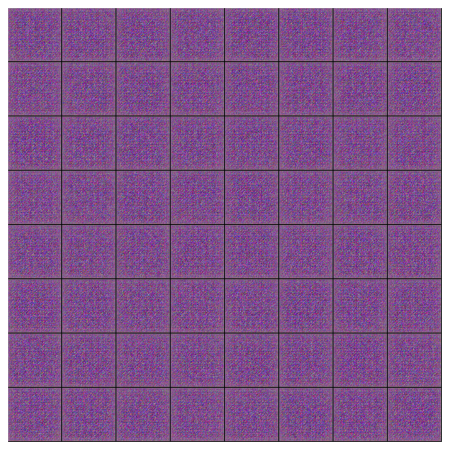

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = nn.BCELoss()

sample_dir = './drive/MyDrive/Gan/generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
model["generator"]

Sequential(
  (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
model["discriminator"]

Sequential(
  (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

# The Model Training

In [ ]:

#from google.colab import files
import sys
sys.path.append('/content/drive/MyDrive/Gan')
# For reloading 
import train
import imp
imp.reload(train)

# learning rate for optimizers
lr = 0.0002

!CUDA_LAUNCH_BLOCKING=1

# number of epochs
epochs = 150
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

history = train.fit(model, train_dl, device, latent_size, fixed_latent, save_samples, criterion, epochs, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/150], loss_g: 11.1544, loss_d: 0.3762, real_score: 0.9189, fake_score: 0.1212


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/150], loss_g: 11.7034, loss_d: 0.2572, real_score: 0.9405, fake_score: 0.0889


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/150], loss_g: 10.3571, loss_d: 0.1954, real_score: 0.9421, fake_score: 0.0697


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/150], loss_g: 7.8182, loss_d: 0.2148, real_score: 0.9262, fake_score: 0.0902


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/150], loss_g: 6.1548, loss_d: 0.5485, real_score: 0.8436, fake_score: 0.1377


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/150], loss_g: 4.6042, loss_d: 0.7389, real_score: 0.8009, fake_score: 0.1840


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/150], loss_g: 3.6666, loss_d: 0.6490, real_score: 0.7909, fake_score: 0.1891


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/150], loss_g: 4.5373, loss_d: 0.6657, real_score: 0.8003, fake_score: 0.1935


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/150], loss_g: 4.1422, loss_d: 0.5951, real_score: 0.7909, fake_score: 0.1883


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/150], loss_g: 3.1013, loss_d: 0.9148, real_score: 0.7324, fake_score: 0.2569


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/150], loss_g: 3.7703, loss_d: 0.6229, real_score: 0.7941, fake_score: 0.2107


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/150], loss_g: 5.1805, loss_d: 0.5280, real_score: 0.8246, fake_score: 0.1796


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/150], loss_g: 5.7872, loss_d: 0.4817, real_score: 0.8443, fake_score: 0.1614


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/150], loss_g: 4.1853, loss_d: 0.7239, real_score: 0.7765, fake_score: 0.2192


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/150], loss_g: 3.9672, loss_d: 0.6742, real_score: 0.7803, fake_score: 0.2258


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/150], loss_g: 3.6882, loss_d: 0.6699, real_score: 0.7672, fake_score: 0.2215


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/150], loss_g: 4.1772, loss_d: 0.7186, real_score: 0.7653, fake_score: 0.2289


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/150], loss_g: 4.1369, loss_d: 0.6127, real_score: 0.7957, fake_score: 0.2112


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/150], loss_g: 4.1689, loss_d: 0.6308, real_score: 0.7934, fake_score: 0.2085


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/150], loss_g: 4.2043, loss_d: 0.7049, real_score: 0.7665, fake_score: 0.2190


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [21/150], loss_g: 4.4212, loss_d: 0.7175, real_score: 0.7615, fake_score: 0.2275


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [22/150], loss_g: 4.0047, loss_d: 0.5962, real_score: 0.7892, fake_score: 0.2115


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [23/150], loss_g: 4.3618, loss_d: 0.7015, real_score: 0.7664, fake_score: 0.2211


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [24/150], loss_g: 4.0249, loss_d: 0.6514, real_score: 0.7853, fake_score: 0.2274


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [25/150], loss_g: 3.9171, loss_d: 0.6127, real_score: 0.7813, fake_score: 0.2104


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [26/150], loss_g: 4.2936, loss_d: 0.5699, real_score: 0.7925, fake_score: 0.1990


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [27/150], loss_g: 4.3868, loss_d: 0.6172, real_score: 0.7854, fake_score: 0.2099


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [28/150], loss_g: 4.2207, loss_d: 0.6976, real_score: 0.7746, fake_score: 0.2298


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [29/150], loss_g: 4.0005, loss_d: 0.5348, real_score: 0.8019, fake_score: 0.1948


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [30/150], loss_g: 4.2600, loss_d: 0.6255, real_score: 0.7874, fake_score: 0.2024


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [31/150], loss_g: 4.2798, loss_d: 0.6223, real_score: 0.7902, fake_score: 0.2085


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [32/150], loss_g: 4.2209, loss_d: 0.5560, real_score: 0.8019, fake_score: 0.1959


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [33/150], loss_g: 4.3643, loss_d: 0.5541, real_score: 0.8051, fake_score: 0.1930


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [34/150], loss_g: 4.5175, loss_d: 0.5612, real_score: 0.8108, fake_score: 0.1919


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [35/150], loss_g: 4.2599, loss_d: 0.6094, real_score: 0.7959, fake_score: 0.1977


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [36/150], loss_g: 4.1711, loss_d: 0.4432, real_score: 0.8280, fake_score: 0.1632


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [37/150], loss_g: 4.6502, loss_d: 0.4525, real_score: 0.8318, fake_score: 0.1668


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [38/150], loss_g: 4.9488, loss_d: 0.5633, real_score: 0.8121, fake_score: 0.1824


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [39/150], loss_g: 4.8329, loss_d: 0.5497, real_score: 0.8147, fake_score: 0.1832


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [40/150], loss_g: 4.8244, loss_d: 0.4651, real_score: 0.8373, fake_score: 0.1679


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [41/150], loss_g: 4.8212, loss_d: 0.4790, real_score: 0.8308, fake_score: 0.1617


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [42/150], loss_g: 4.6627, loss_d: 0.4099, real_score: 0.8405, fake_score: 0.1477


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [43/150], loss_g: 5.0169, loss_d: 0.5563, real_score: 0.8240, fake_score: 0.1832


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [44/150], loss_g: 4.7261, loss_d: 0.4935, real_score: 0.8438, fake_score: 0.1540


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [45/150], loss_g: 4.2613, loss_d: 0.3437, real_score: 0.8592, fake_score: 0.1355


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [46/150], loss_g: 4.8844, loss_d: 0.3779, real_score: 0.8583, fake_score: 0.1351


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [47/150], loss_g: 4.6906, loss_d: 0.3415, real_score: 0.8702, fake_score: 0.1302


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [48/150], loss_g: 5.1130, loss_d: 0.4714, real_score: 0.8413, fake_score: 0.1573


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [49/150], loss_g: 4.7247, loss_d: 0.3603, real_score: 0.8629, fake_score: 0.1332


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [50/150], loss_g: 4.8531, loss_d: 0.5118, real_score: 0.8362, fake_score: 0.1681


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [51/150], loss_g: 4.8163, loss_d: 0.4217, real_score: 0.8576, fake_score: 0.1284


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [52/150], loss_g: 4.6720, loss_d: 0.5694, real_score: 0.8233, fake_score: 0.1843


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [53/150], loss_g: 4.3978, loss_d: 0.2696, real_score: 0.8916, fake_score: 0.1092


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [54/150], loss_g: 5.0304, loss_d: 0.4444, real_score: 0.8567, fake_score: 0.1393


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [55/150], loss_g: 4.8023, loss_d: 0.2840, real_score: 0.8854, fake_score: 0.1145


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [56/150], loss_g: 4.6986, loss_d: 0.5577, real_score: 0.8257, fake_score: 0.1647


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [57/150], loss_g: 4.7484, loss_d: 0.4355, real_score: 0.8568, fake_score: 0.1478


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [58/150], loss_g: 4.6533, loss_d: 0.2803, real_score: 0.8868, fake_score: 0.1068


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [59/150], loss_g: 4.7765, loss_d: 0.3246, real_score: 0.8828, fake_score: 0.1225


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [60/150], loss_g: 5.0402, loss_d: 0.4126, real_score: 0.8670, fake_score: 0.1224


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [61/150], loss_g: 4.9329, loss_d: 0.3718, real_score: 0.8716, fake_score: 0.1376


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [62/150], loss_g: 5.1671, loss_d: 0.4109, real_score: 0.8599, fake_score: 0.1356


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [63/150], loss_g: 4.7200, loss_d: 0.3189, real_score: 0.8847, fake_score: 0.1162


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [64/150], loss_g: 4.8552, loss_d: 0.3126, real_score: 0.8905, fake_score: 0.1126


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [65/150], loss_g: 5.0387, loss_d: 0.3369, real_score: 0.8779, fake_score: 0.1175


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [66/150], loss_g: 4.9871, loss_d: 0.2605, real_score: 0.8986, fake_score: 0.1003


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [67/150], loss_g: 4.9120, loss_d: 0.2785, real_score: 0.8935, fake_score: 0.1021


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [68/150], loss_g: 5.5453, loss_d: 0.5359, real_score: 0.8522, fake_score: 0.1479


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [69/150], loss_g: 4.8969, loss_d: 0.3768, real_score: 0.8712, fake_score: 0.1284


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [70/150], loss_g: 4.6703, loss_d: 0.2404, real_score: 0.9012, fake_score: 0.0932


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [71/150], loss_g: 4.9808, loss_d: 0.3839, real_score: 0.8712, fake_score: 0.1289


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [72/150], loss_g: 4.8735, loss_d: 0.3114, real_score: 0.8898, fake_score: 0.1080


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [73/150], loss_g: 4.6468, loss_d: 0.2504, real_score: 0.9019, fake_score: 0.0968


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [74/150], loss_g: 5.7867, loss_d: 0.6884, real_score: 0.8219, fake_score: 0.1821


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [75/150], loss_g: 4.1558, loss_d: 0.2399, real_score: 0.8999, fake_score: 0.0898


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [76/150], loss_g: 4.8327, loss_d: 0.3682, real_score: 0.8849, fake_score: 0.1253


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [77/150], loss_g: 4.8060, loss_d: 0.2144, real_score: 0.9124, fake_score: 0.0856


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [78/150], loss_g: 5.4844, loss_d: 0.3482, real_score: 0.8930, fake_score: 0.1089


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [79/150], loss_g: 5.2017, loss_d: 0.2945, real_score: 0.8882, fake_score: 0.1059


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [80/150], loss_g: 4.8454, loss_d: 0.2707, real_score: 0.9011, fake_score: 0.0980


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [81/150], loss_g: 5.6674, loss_d: 0.4439, real_score: 0.8641, fake_score: 0.1372


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [82/150], loss_g: 4.6580, loss_d: 0.1909, real_score: 0.9211, fake_score: 0.0783


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [83/150], loss_g: 4.8750, loss_d: 0.1927, real_score: 0.9191, fake_score: 0.0749


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [84/150], loss_g: 4.9345, loss_d: 0.1952, real_score: 0.9205, fake_score: 0.0763


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [85/150], loss_g: 5.8423, loss_d: 0.6161, real_score: 0.8379, fake_score: 0.1698


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [86/150], loss_g: 4.6920, loss_d: 0.1967, real_score: 0.9200, fake_score: 0.0799


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [87/150], loss_g: 4.6841, loss_d: 0.1783, real_score: 0.9237, fake_score: 0.0719


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [88/150], loss_g: 5.4277, loss_d: 0.5239, real_score: 0.8507, fake_score: 0.1505


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [89/150], loss_g: 4.6450, loss_d: 0.1869, real_score: 0.9223, fake_score: 0.0768


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [90/150], loss_g: 4.6266, loss_d: 0.1436, real_score: 0.9371, fake_score: 0.0632


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [91/150], loss_g: 5.7001, loss_d: 0.4687, real_score: 0.8643, fake_score: 0.1350


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [92/150], loss_g: 5.3220, loss_d: 0.3302, real_score: 0.8858, fake_score: 0.1124


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [93/150], loss_g: 4.8679, loss_d: 0.1799, real_score: 0.9261, fake_score: 0.0713


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [94/150], loss_g: 5.3125, loss_d: 0.2433, real_score: 0.9110, fake_score: 0.0915


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [95/150], loss_g: 5.2599, loss_d: 0.2343, real_score: 0.9145, fake_score: 0.0844


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [96/150], loss_g: 5.5040, loss_d: 0.2411, real_score: 0.9086, fake_score: 0.0903


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [97/150], loss_g: 4.6565, loss_d: 0.1495, real_score: 0.9337, fake_score: 0.0532


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [98/150], loss_g: 5.1845, loss_d: 0.8007, real_score: 0.8349, fake_score: 0.1794


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [99/150], loss_g: 4.7018, loss_d: 0.2865, real_score: 0.8944, fake_score: 0.0980


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [100/150], loss_g: 4.7975, loss_d: 0.2629, real_score: 0.9109, fake_score: 0.0957


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [101/150], loss_g: 4.4657, loss_d: 0.1538, real_score: 0.9307, fake_score: 0.0600


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [102/150], loss_g: 5.2887, loss_d: 0.4662, real_score: 0.8845, fake_score: 0.1232


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [103/150], loss_g: 4.7581, loss_d: 0.1592, real_score: 0.9309, fake_score: 0.0669


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [104/150], loss_g: 4.7584, loss_d: 0.1607, real_score: 0.9323, fake_score: 0.0644


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [105/150], loss_g: 5.0856, loss_d: 0.1730, real_score: 0.9290, fake_score: 0.0683


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [106/150], loss_g: 5.2923, loss_d: 0.3520, real_score: 0.8843, fake_score: 0.1141


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [107/150], loss_g: 4.7787, loss_d: 0.4649, real_score: 0.8751, fake_score: 0.1236


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [108/150], loss_g: 5.5347, loss_d: 0.3817, real_score: 0.8852, fake_score: 0.1196


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [109/150], loss_g: 4.6183, loss_d: 0.1739, real_score: 0.9250, fake_score: 0.0681


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [110/150], loss_g: 5.1510, loss_d: 0.5264, real_score: 0.8580, fake_score: 0.1404


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [111/150], loss_g: 5.0767, loss_d: 0.3942, real_score: 0.8907, fake_score: 0.1202


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [112/150], loss_g: 4.4081, loss_d: 0.1291, real_score: 0.9416, fake_score: 0.0571


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [113/150], loss_g: 4.6386, loss_d: 0.1121, real_score: 0.9503, fake_score: 0.0501


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [114/150], loss_g: 4.7242, loss_d: 0.1232, real_score: 0.9446, fake_score: 0.0516


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [115/150], loss_g: 4.8751, loss_d: 0.1094, real_score: 0.9538, fake_score: 0.0496


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [116/150], loss_g: 4.9699, loss_d: 0.1270, real_score: 0.9445, fake_score: 0.0512


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [117/150], loss_g: 6.3520, loss_d: 0.9049, real_score: 0.8090, fake_score: 0.2004


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [118/150], loss_g: 4.5868, loss_d: 0.1830, real_score: 0.9224, fake_score: 0.0750


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [119/150], loss_g: 4.4096, loss_d: 0.1397, real_score: 0.9391, fake_score: 0.0599


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [120/150], loss_g: 4.5667, loss_d: 0.1170, real_score: 0.9470, fake_score: 0.0517


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [121/150], loss_g: 4.8968, loss_d: 0.1375, real_score: 0.9428, fake_score: 0.0575


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [122/150], loss_g: 4.9436, loss_d: 0.2467, real_score: 0.9149, fake_score: 0.0843


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [123/150], loss_g: 5.1894, loss_d: 0.1078, real_score: 0.9526, fake_score: 0.0458


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [124/150], loss_g: 5.0528, loss_d: 0.1102, real_score: 0.9517, fake_score: 0.0475


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [125/150], loss_g: 5.4824, loss_d: 0.3149, real_score: 0.9171, fake_score: 0.0882


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [126/150], loss_g: 5.9157, loss_d: 0.7773, real_score: 0.8221, fake_score: 0.1779


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [127/150], loss_g: 4.5380, loss_d: 0.1716, real_score: 0.9265, fake_score: 0.0692


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [128/150], loss_g: 4.6073, loss_d: 0.1371, real_score: 0.9370, fake_score: 0.0544


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [129/150], loss_g: 5.1809, loss_d: 0.3892, real_score: 0.8991, fake_score: 0.1093


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [130/150], loss_g: 4.7572, loss_d: 0.1204, real_score: 0.9479, fake_score: 0.0521


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [131/150], loss_g: 4.7450, loss_d: 0.0970, real_score: 0.9553, fake_score: 0.0417


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [132/150], loss_g: 4.9008, loss_d: 0.1031, real_score: 0.9516, fake_score: 0.0414


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [133/150], loss_g: 5.2733, loss_d: 0.5968, real_score: 0.8655, fake_score: 0.1430


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [134/150], loss_g: 4.9048, loss_d: 0.1261, real_score: 0.9446, fake_score: 0.0528


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [135/150], loss_g: 4.9591, loss_d: 0.1220, real_score: 0.9489, fake_score: 0.0526


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [136/150], loss_g: 5.1814, loss_d: 0.1051, real_score: 0.9539, fake_score: 0.0457


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [137/150], loss_g: 5.1062, loss_d: 0.0791, real_score: 0.9649, fake_score: 0.0363


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [138/150], loss_g: 5.6259, loss_d: 0.5889, real_score: 0.8575, fake_score: 0.1395


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [139/150], loss_g: 4.9606, loss_d: 0.1376, real_score: 0.9429, fake_score: 0.0595


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [140/150], loss_g: 4.8846, loss_d: 0.2727, real_score: 0.9249, fake_score: 0.0736


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [141/150], loss_g: 4.8573, loss_d: 0.1891, real_score: 0.9298, fake_score: 0.0701


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [142/150], loss_g: 4.8893, loss_d: 0.0911, real_score: 0.9593, fake_score: 0.0407


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [143/150], loss_g: 5.0242, loss_d: 0.0689, real_score: 0.9677, fake_score: 0.0321


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [144/150], loss_g: 5.1650, loss_d: 0.0612, real_score: 0.9707, fake_score: 0.0279


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [145/150], loss_g: 5.4031, loss_d: 0.0734, real_score: 0.9679, fake_score: 0.0335


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [146/150], loss_g: 5.3563, loss_d: 0.0591, real_score: 0.9730, fake_score: 0.0268


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [147/150], loss_g: 5.8271, loss_d: 0.2773, real_score: 0.9355, fake_score: 0.0526


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [148/150], loss_g: 5.3786, loss_d: 0.9368, real_score: 0.8214, fake_score: 0.1922


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [149/150], loss_g: 4.7084, loss_d: 0.1786, real_score: 0.9275, fake_score: 0.0717


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [150/150], loss_g: 4.7599, loss_d: 0.1379, real_score: 0.9419, fake_score: 0.0594


In [ ]:
import imageio
import shutil
RES_DIR = '/content/drive/MyDrive/Gan/generated'
images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('training_visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)

In [ ]:
from IPython.display import Image
Image(open('training_visual.gif','rb').read())

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history


In [ ]:
!mv  training_visual.gif /content/drive/MyDrive/Gan


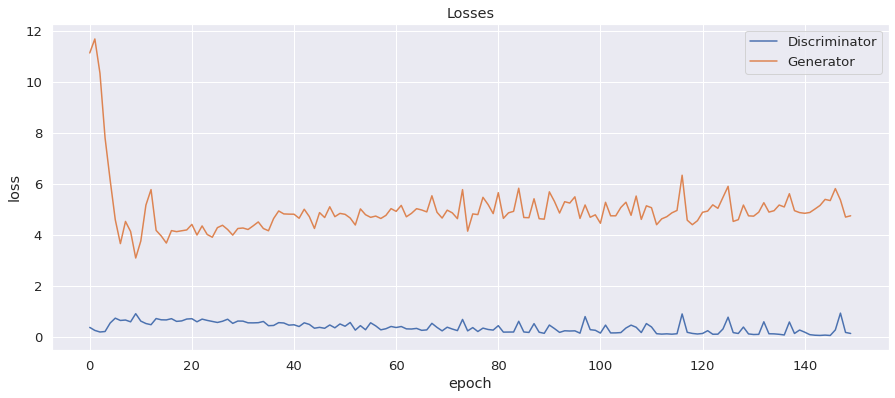

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

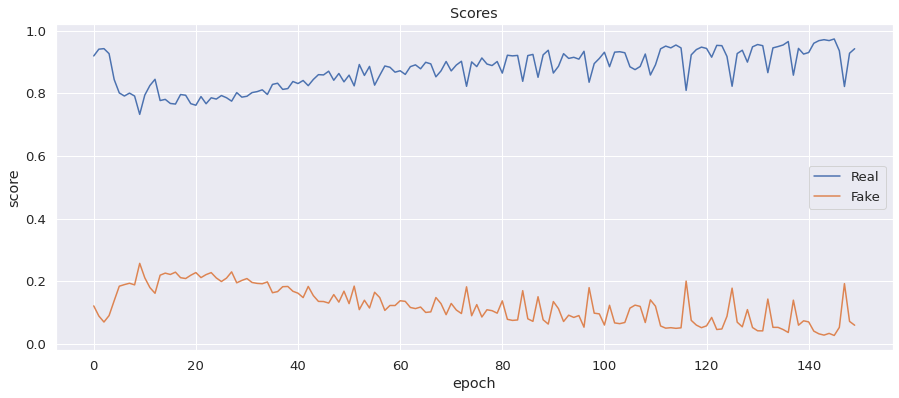

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

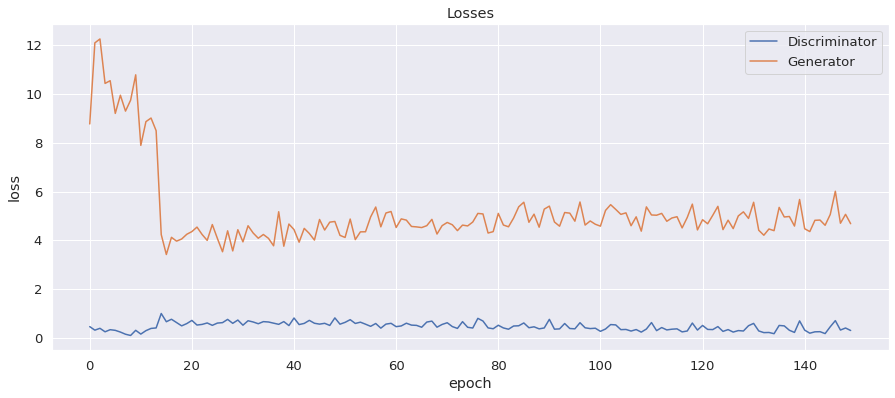

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [ ]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Image Generation

In [ ]:
PATH = "./drive/MyDrive/Gan/" lr = 0.0002
CUDA_LAUNCH_BLOCKING=1
# number of epochs
epochs=150

In [ ]:
import imageio
generated_img = imageio.imread(f'/content/drive/MyDrive/Gan/generated/generated-images-0150.png')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Image(open('training_visual.gif','rb').read())

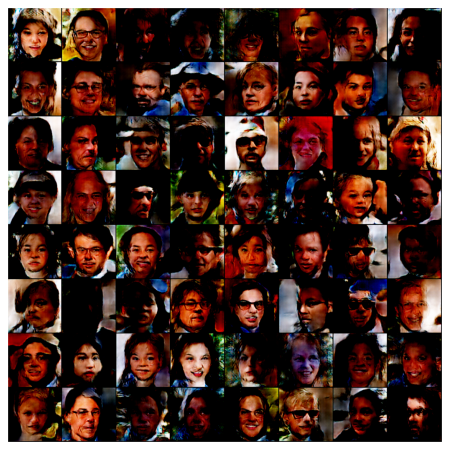

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8)) # 200 эпох обучения с latent_size = 256
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

In [ ]:
PATH1 =  '/content/drive/MyDrive/generator_model.pt'
PATH2 =  '/content/drive/MyDrive/discriminator_model.pt'
model['generator'].load_state_dict(torch.load(PATH1))
model['discriminator'].load_state_dict(torch.load(PATH2))

<All keys matched successfully>

In [ ]:
n_images = 64
model['generator'].eval()
fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = model['generator'](fixed_latent).cpu()

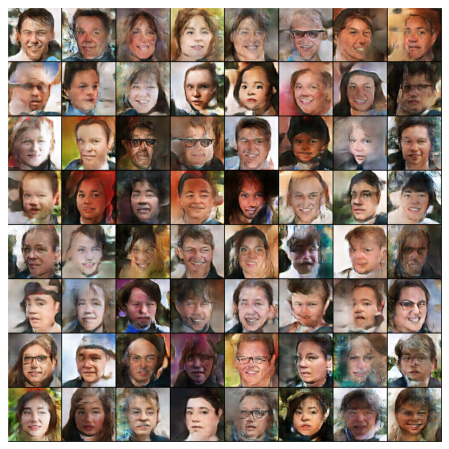

In [ ]:
show_images(fake_images, nmax=n_images) # 200 gan

In [ ]:
generated_img = imageio.imread(f'/content/drive/MyDrive/Gan/generated/generated-images-0149.png')


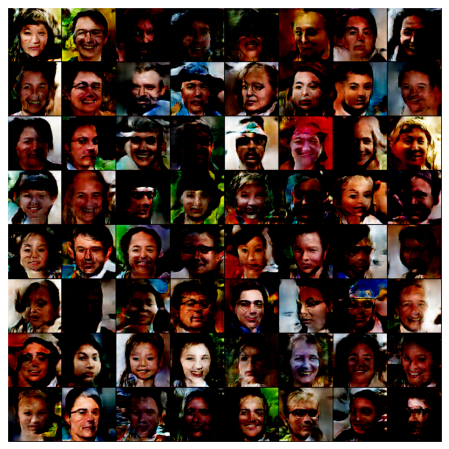

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8)) # 100 эпох обучения с latent_size = 256
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(generated_img)

In [ ]:
latent_size = 256
fixed_latent = torch.randn(256, latent_size, 1, 1, device=device)

In [ ]:
n_images = 64
model['generator'].eval()
#fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = model['generator'](fixed_latent).cpu()

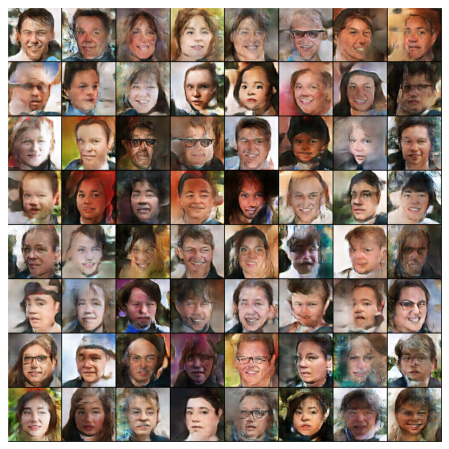

In [ ]:
show_images(fake_images, nmax=n_images) # 30 gan

In [ ]:
n_images = 64
model['generator'].eval()
#fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = model['generator'](fixed_latent).cpu()

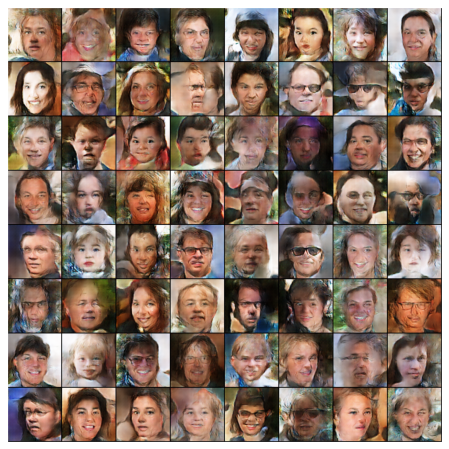

In [ ]:
show_images(fake_images, nmax=n_images)

## Classification of Generated Images

In [ ]:
train_ds = ImageFolder('/content/drive/MyDrive/faces_dataset_small',  transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
# 1000 real images
dataset_subset = torch.utils.data.Subset(train_ds, np.random.choice(len(train_ds), 1000, replace=False))

In [ ]:
%%time

real = None

for image, _ in dataset_subset:
    if real is None:
         real = image.flatten()
    else:
         real = np.vstack([real, image.flatten()])

CPU times: user 1min 16s, sys: 6.26 s, total: 1min 22s
Wall time: 1min 24s


In [ ]:
real.shape 

(1000, 49152)

In [ ]:
# 1000 generated images
batch_size = 1000
fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
with torch.no_grad():
    fake_images = model['generator'](fixed_latent).cpu()

In [ ]:
fake = fake_images.reshape(fake_images.shape[0], 3*128*128)    

fake.shape

torch.Size([1000, 49152])

In [ ]:
X = np.vstack([real, fake.detach().numpy()])
y = np.vstack([np.ones(len(real)),np.zeros(len(fake))]).flatten()
print(X.shape)
print(y.shape)

(2000, 49152)
(2000,)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.decomposition import PCA
clf = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()

In [ ]:
pca = PCA(n_components=200)
pca_result = pca.fit_transform(X)

In [ ]:
pca_result.shape

(2000, 200)

In [ ]:
actual = []
predicted = []
for train_index, test_index in loo.split(pca_result, y):
    X_train, X_test = pca_result[train_index], pca_result[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # Append the single predictions and actual values here.
    actual.append(y_test)
    predicted.append(y_pred)
    
    # Outside the loop, calculate the accuracy.
  
print('Accuracy 1NN Classifier on fake and real images data', end=' ')
print(*sum(np.array(predicted) == np.array(actual)) / len(predicted)) 

Accuracy 1NN Classifier on fake and real images data 0.681


## Visualisation of Generated and Real Images

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X) 


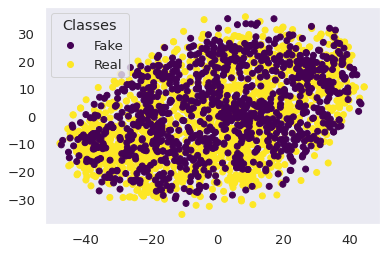

In [ ]:
labels = ['Fake', 'Real']
scatter = plt.scatter(tsne_result[:,0],tsne_result[:,1],  c=y, cmap='viridis')
handles, _ = scatter.legend_elements(prop='colors')
plt.grid(False)
plt.legend(handles, labels, title="Classes")

As we can see, we got a good result, generated images are quite similar with the real ones.